In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

#**Loading the datasets**

In [3]:
# laoding the datasets without target variable
(X_train, _), (X_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


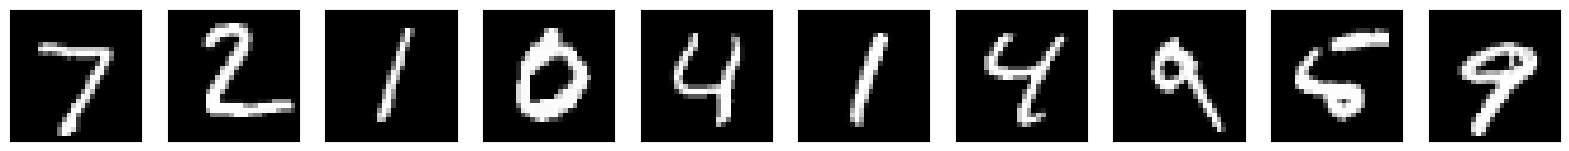

In [4]:

# number of digits to display
n = 10

# create a figure to display the images
plt.figure(figsize=(20, 4))

# loop through the first n images
for i in range(n):
   ax = plt.subplot(1,n,i+1)

   plt.imshow(X_test[i].reshape(28,28))

   plt.gray()
   ax.get_xaxis().set_visible(False)
   ax.get_yaxis().set_visible(False)


plt.show()
plt.close()

In [5]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape((len(X_train), 28*28*1))
X_test = X_test.reshape((len(X_test), 28*28*1))
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


#**Convolutional Autoencoders**

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model

#**Architecture of auto encoders**

In [10]:
input_layer_cnv = Input(shape = (28,28,1))
ae_cnv_en = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(input_layer_cnv)
ae_cnv_en = MaxPooling2D((2,2), padding='same')(ae_cnv_en)

ae_cnv_en = Conv2D(32, (3,3), activation='relu', padding='same')(ae_cnv_en)
ae_cnv_en = MaxPooling2D((2,2), padding='same')(ae_cnv_en)

ae_cnv_en = Conv2D(4, (3,3), activation='relu', padding='same')(ae_cnv_en)
ae_cnv_en = MaxPooling2D((2,2), padding='same')(ae_cnv_en)

ae_cnv_en= Flatten(name='bot')(ae_cnv_en)

ae_cnv_en = Reshape((4,4,4), input_shape = (64,), name = 'botnext0')(ae_cnv_en)
ae_cnv_en = Conv2D(4, (3,3), activation='relu', padding = 'same', name = 'botnext1')(ae_cnv_en)
ae_cnv_en = UpSampling2D((2,2), name = 'botnext2')(ae_cnv_en)

ae_cnv_en = Conv2D(32, (3,3), activation='relu', padding = 'same', name = 'botnext3')(ae_cnv_en)
ae_cnv_en = UpSampling2D((2,2), name = 'botnext4')(ae_cnv_en)

ae_cnv_en = Conv2D(32, (3,3), activation='relu', padding = 'same', name = 'botnext5')(ae_cnv_en)
ae_cnv_en = UpSampling2D((2,2), name = 'botnext6')(ae_cnv_en)

ae_cnv_en = Conv2D(1, (3,3), activation='sigmoid', padding = 'same', name = 'botnext7')(ae_cnv_en)
Ae_Conv = Model(inputs = input_layer_cnv, outputs = ae_cnv_en)

Ae_Conv.compile(optimizer=tf.keras.optimizers.SGD(0.09, clipvalue=2.5), loss='binary_crossentropy', metrics=['accuracy'])

Ae_Conv.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 4)           1156

#**Encoder**

In [13]:
ae_conv_encoder = Model (inputs = input_layer_cnv, outputs = Ae_Conv.get_layer("bot").output, name = "Conv_AE_encoder")
ae_conv_encoder.summary()

Model: "Conv_AE_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 4)       

#**Decoder**

In [15]:
encode_inp_cnv = Input(shape = (64,))
tmp_dec = Ae_Conv.get_layer("botnext0")(encode_inp_cnv)

for i in range(1,8):
  st = "botnext{}".format(i)
  tmp_dec = Ae_Conv.get_layer(st)(tmp_dec)

ae_conv_decoder = Model(inputs = encode_inp_cnv, outputs = tmp_dec, name="Conv_AE_decoder")
ae_conv_decoder.summary()

Model: "Conv_AE_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64)]              0         
                                                                 
 botnext0 (Reshape)          (None, 4, 4, 4)           0         
                                                                 
 botnext1 (Conv2D)           (None, 4, 4, 4)           148       
                                                                 
 botnext2 (UpSampling2D)     (None, 8, 8, 4)           0         
                                                                 
 botnext3 (Conv2D)           (None, 8, 8, 32)          1184      
                                                                 
 botnext4 (UpSampling2D)     (None, 16, 16, 32)        0         
                                                                 
 botnext5 (Conv2D)           (None, 16, 16, 32)    

In [16]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [23]:
%cd /content/drive/MyDrive/Colab Notebooks




/content/drive/MyDrive/Colab Notebooks


In [24]:
!ls

'Lecture_12 state4_basics_of_python.ipynb'   Lecture_25.ipynb		  Untitled0.ipynb
 Lecture_22_MNIST_classification.ipynb	     Lecture_27.ipynb		  Untitled1.ipynb
 Lecture_23.ipynb			    'python_7th semester.ipynb'


In [25]:
!apt-get install -y git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [26]:
!git config --global user.email "owaisahmad014@email.com"
!git config --global user.name "Owais Ahmad"


In [27]:
!git init


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/drive/MyDrive/Colab Notebooks/.git/
